In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-13 12:57:48.893019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 12:57:49.491145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5


# Additive model:  two-latent functions

        y = f(x) + g(x) + e
        f = GP(0, RBF)
        g = GP(0, Periodic)

Noise variance is not trained.

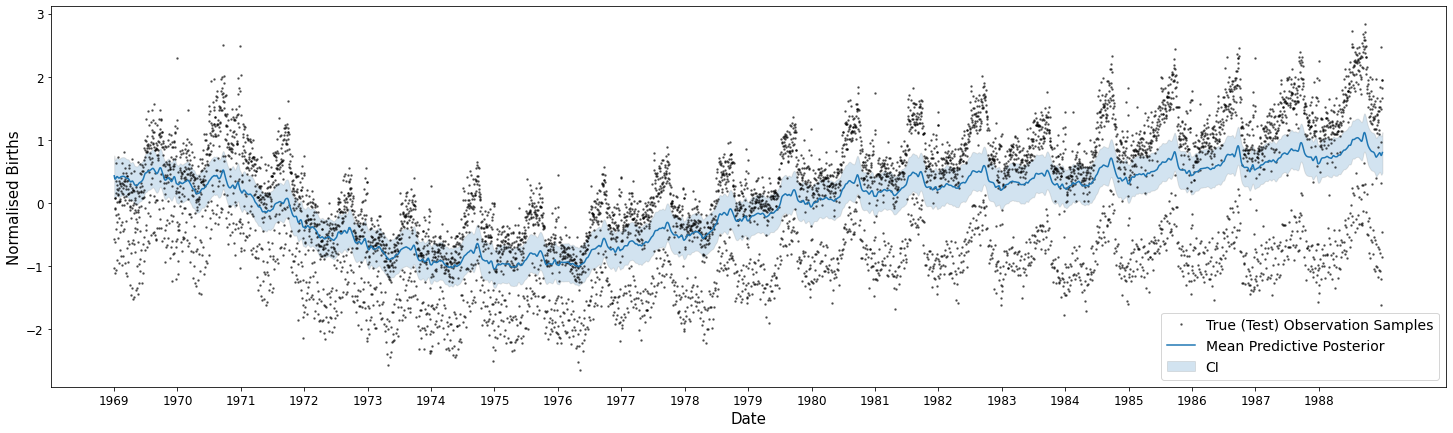

Fitted values MSE:  0.6091584529448275
Log-marginal likelihood:  -9159.317977588624
Percentage of points out of CI:  74.05886379192333


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0293187
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,5.56399
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.998057
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,1.00012
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


In [5]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF())

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Not a very good fit. The period parameter value doesn't really make sense. Should be yearly periodic.

Set period to mean average of days per year and don't train it.

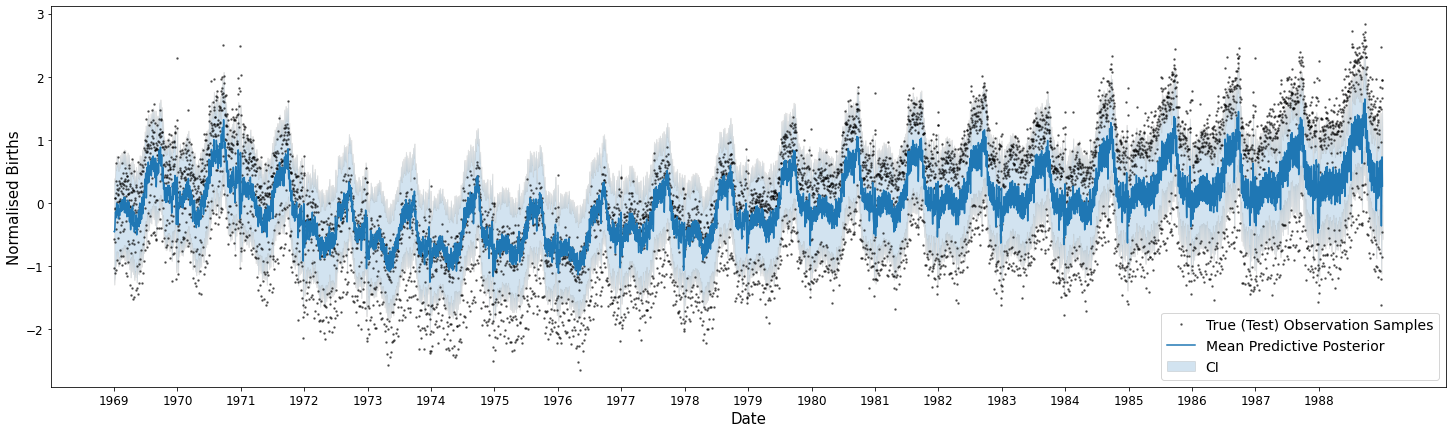

Fitted values MSE:  0.45556215463456534
Log-marginal likelihood:  -9674.272486034979
Percentage of points out of CI:  32.42984257357974


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.293209
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.10058
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.0817399
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.256295
GPR.kernel.kernels[1].period,Parameter,Softplus,,False,(),float64,365.25
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


In [5]:
# re-build model & set period

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Worse fit !!! The CI is also not good enough(?)

Add priors to penalised small length scales. 

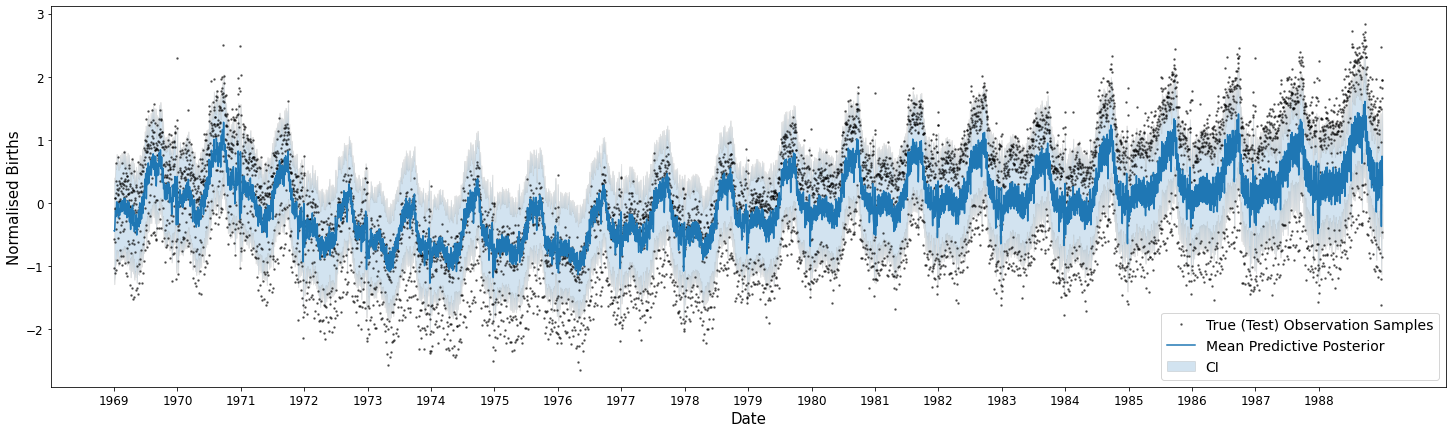

Fitted values MSE:  0.45407092511846764
Log-marginal likelihood:  -9675.879666018072
Percentage of points out of CI:  31.90965092402464


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.297434
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,2.10001
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.282341
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.717289
GPR.kernel.kernels[1].period,Parameter,Softplus,,False,(),float64,365.25
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


In [4]:
# add prior to hyperparameters

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

# adding priors
model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

No improvement. Maybe starting conditions will generate better fit.

Investigate how the hyperparameter starting point affects the fitting of the model.

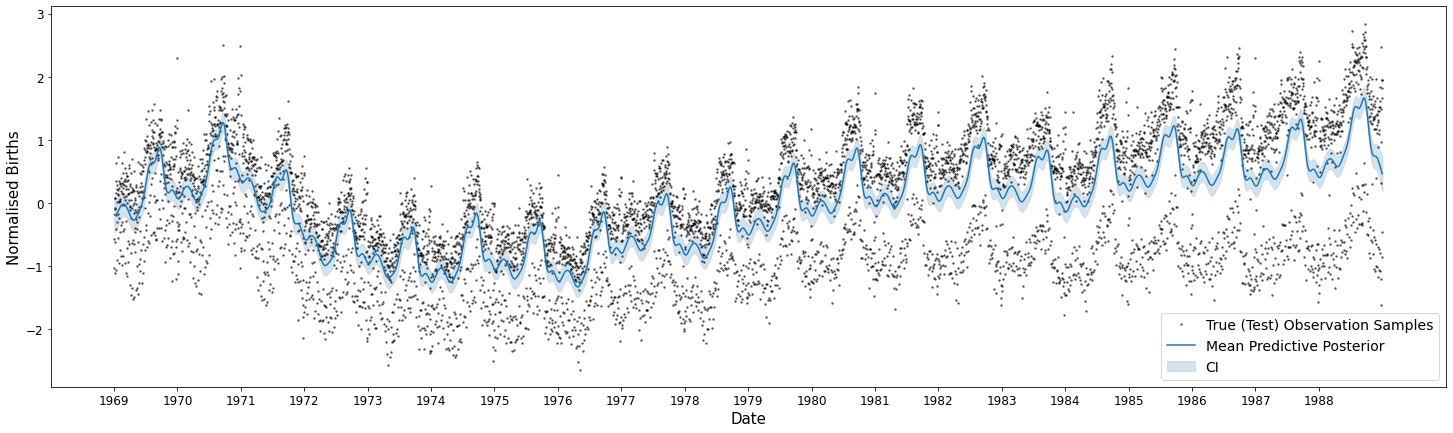

Fitted values MSE:  0.550096878345392
Log-marginal likelihood:  -8832.998966801333
Percentage of points out of CI:  91.56741957563312


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.237621
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,181.078
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.152081
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.274722
GPR.kernel.kernels[1].period,Parameter,Softplus,,False,(),float64,365.25
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


In [6]:
# add prior to hyperparameters

kernel = gpflow.kernels.RBF(lengthscales=5) + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

# adding priors
model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

_______________________
_______________________

Since we have already investigated the effect of prior to be good in basic gp, we leave this additive GPR model and move to additive SVGP model.